<a href="https://colab.research.google.com/github/bderdz/pet_care_assistant/blob/main/AI_Pet_Care_Assistant_Capstone_2025Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gen_ai_intensive_course_capstone_2025q1_path = kagglehub.competition_download('gen-ai-intensive-course-capstone-2025q1')

print('Data source import complete.')


# AI Pet Care Assistant

### 🔎 Introduction
As a pet owner, I know how hard is it to rise and care for an animal. There were situations that i wish someone/something would explain me how to do it. So i came up with an idea to make an AI Pet Care Assistant. Which can generate diet, activity, health care plan and answer for your questions about your pet. All based on your pet profile that you give to the Assistant and additional documents about pets (RAG) or also by using Google Search grounding.

### 🐾 Key Features
- **Personalized Diet Recommendations** – based on pet species, age, weight, and health conditions
- **Custom Activity Suggestions** – including exercise and playtime ideas tailored to the pet's needs
- **Health Care Guidance** – covering preventive care, common issues, and regular routines
- **Q&A Support** – get instant answers to pet-related questions
- **Full Pet Care Plan Generation** – receive a complete, structured plan to help you care for your pet in the best possible way

### ⚙️ Capabilites Used:
- **Agent with LangGraph**
- **Retrieval augmented generation (RAG)**
- **Google Search Grounding**
- **Structured output**


## 🔨 Setting up

In [ ]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' "google-genai==1.7.0" "chromadb==0.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:0

#### API key

In [ ]:
import os
# from kaggle_secrets import UserSecretsClient
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from google import genai
client = genai.Client(api_key=GOOGLE_API_KEY)

#### Automated retry

In [ ]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## RAG
This section implements the core logic of the assistant using a Retrieval-Augmented Generation (RAG).

I use a few documents includes information about diets for cats and dogs, activities and health care to create an embedding database.
_If Agent didnt find information in this documents he will use google search grounding to answer the question_

In [ ]:
# Cat diet
DOCUMENT1 = """
Adult domestic cats require on average 50 to 70 kilocalories per kilogram of body weight per day. A healthy intact adult cat weighing 4.5 kg will typically need 225 to 315 kcal per day, depending on activity level and environment. Neutered cats require less energy due to lower metabolic rate. For a neutered cat of the same weight, the daily caloric requirement is approximately 180 to 220 kcal.
Neutered cats are at higher risk of obesity and urinary tract problems. Their diet should include high protein (at least 35% of dry matter), moderate fat (10–15%), and reduced energy density. Commercial diets for neutered cats often provide 300–350 kcal per 100g for dry food and around 80–100 kcal per 100g for wet food. Feeding guidelines should follow manufacturer recommendations, adjusted for individual condition and activity.
Non-neutered cats with access to the outdoors may require higher energy intake, up to 300 kcal/day for a 4.5 kg cat. Their diet should remain rich in animal protein (above 30% dry matter), with fat content around 15–20%, and limited carbohydrates (<10%). These cats benefit from a mix of wet and dry food, or high-quality raw diets formulated to meet FEDIAF or AAFCO standards.
Feeding frequency for adult cats should be 2 to 3 times per day. Free feeding is discouraged for neutered indoor cats due to the risk of overeating. Kittens up to 6 months should be fed 3–4 times daily with energy-dense food (up to 100 kcal per kg body weight). Senior cats (above 10 years) often require adjusted diets with reduced phosphorus and added omega-3 for kidney and joint health.
Water intake is critical. Daily water requirement is about 40–60 ml per kilogram of body weight. For a 4.5 kg cat, this equals 180–270 ml daily. Wet food typically contains 70–80% moisture, providing hydration as part of the diet. For cats eating dry food (7–10% moisture), additional water must be provided. Cats often prefer running water; a fountain can increase fluid intake.
Essential nutrients include taurine (minimum 25 mg/100 kcal), arachidonic acid, vitamin A (not beta-carotene), and niacin. Deficiencies in these nutrients lead to severe health issues. Commercial diets should comply with FEDIAF or AAFCO nutritional profiles. Home-prepared or raw diets must be balanced with professional guidance to avoid deficiencies or excesses.
Obesity prevention includes body condition scoring, meal control, and activity enrichment. Puzzle feeders and scheduled play (at least 15–20 minutes daily) help stimulate activity. For overweight neutered cats, caloric restriction to 70–80% of maintenance energy needs may be necessary, under veterinary supervision. Gradual weight loss (1–2% per week) is recommended.
Treats should not exceed 10% of daily caloric intake. Avoid toxic human foods such as onions, garlic, chocolate, grapes, raisins, alcohol, caffeine, and bones. Milk and dairy often cause gastrointestinal upset due to lactose intolerance. Raw fish or liver should only be given in moderation and properly handled.
"""
# Dog diet
DOCUMENT2 = """
Adult dogs require between 95 to 130 kilocalories per kilogram of metabolic body weight (kg^0.75) per day. The specific caloric needs vary depending on size, breed, activity level, and neuter status. For example, a 20 kg neutered adult dog with moderate activity may need around 800 to 950 kcal/day, while an intact working dog of the same weight may require 1,100 to 1,400 kcal/day.
Neutered dogs typically have reduced energy needs (by 20–25%) due to hormonal changes affecting metabolism and appetite regulation. To prevent obesity, caloric intake should be adjusted accordingly. Diets for neutered dogs should be lower in fat (8–12% dry matter), high in digestible protein (above 22–25% dry matter), and include fiber (2.5–5%) to promote satiety.
Feeding frequency should be 2 meals per day for most adult dogs. Smaller breeds with high metabolic rates may benefit from 3 meals. Large and deep-chested breeds are prone to gastric torsion (bloat), so feeding should be divided into multiple smaller meals with rest before and after.
Water is essential, with dogs needing about 50–60 ml per kilogram of body weight per day. A 20 kg dog should consume 1–1.2 liters daily. Wet food (75–80% moisture) contributes to hydration; dry food (8–10%) requires access to clean water at all times. Increased water intake is necessary in hot climates or for active dogs.
Dry food (kibble) typically provides 350–450 kcal per 100g, while wet food delivers 70–100 kcal per 100g. Portioning should consider not just weight but also activity and condition. Overfeeding dry kibble is a common cause of weight gain in indoor or low-exercise dogs.
Macronutrient recommendations for adult maintenance diets:
- Protein: 18–25% (dry matter); higher for active or athletic dogs
- Fat: 8–15% (dry matter); active dogs may require up to 20%
- Carbohydrates: 30–50% (dry matter), including digestible starches and fiber
- Fiber: 2–5%; moderate levels support digestive health
Essential micronutrients include calcium (1–2%), phosphorus (0.8–1.6%), vitamin E (minimum 50 IU/kg), vitamin D (minimum 500 IU/kg), B-vitamins, and omega-3 fatty acids (e.g., DHA and EPA from fish oil). Commercial foods formulated to AAFCO or FEDIAF standards provide these in adequate proportions.
Obesity is one of the most common nutritional disorders in dogs. Weight gain should be prevented through portion control, use of low-calorie treats (not exceeding 10% of daily calories), and daily exercise (at least 30 minutes of walking or play). Weight loss protocols typically reduce energy intake to 70% of maintenance needs, with regular monitoring of body condition score (BCS).
Dogs with medical conditions (e.g., diabetes, kidney disease, food allergies) require specialized diets. Veterinary therapeutic diets are formulated for these cases and should be used under supervision. Transitioning to a new diet should be gradual, over 5–7 days, to avoid gastrointestinal upset.
Homemade or raw diets must be nutritionally complete and balanced. Common deficiencies in DIY diets include calcium, vitamin D, and zinc. All homemade feeding should be based on veterinary-approved recipes and ideally monitored with periodic bloodwork.
Dangerous foods for dogs include chocolate, onions, garlic, grapes, raisins, alcohol, caffeine, xylitol, and cooked bones. High-fat table scraps can cause pancreatitis. Dairy is poorly tolerated in some adult dogs. Treats such as jerky or biscuits should be carefully portioned to avoid excess calorie intake.
Monitoring stool quality, coat condition, and weight provides early indicators of dietary sufficiency. Adjustments should be based on regular assessment and guided by a veterinarian or certified nutritionist.
"""
# Dog Activity by Age and Breed
DOCUMENT3 = """
Dogs require daily physical exercise to maintain their health. Regular physical activity is essential to prevent obesity, promote good cardiovascular health, and reduce anxiety. The level of activity depends on the breed, age, and health of the dog.
For highly active breeds, such as Border Collies, Huskies, and Labrador Retrievers, vigorous exercise is necessary. These breeds thrive on activities like Long runs, Fetch, Agility training, Herding or pulling activities (for working breeds).
Less active breeds, such as Bulldogs, Pugs, and Dachshunds, require less intense exercise. Daily walks are still important, but these dogs do not require as much vigorous activity. Shorter walks or playtime in a small yard may be sufficient.
Puppies generally have a lot of energy and need more frequent play and shorter walks, while senior dogs may need more rest. It is important to adjust the level of activity according to the dog’s age and health.
Mental stimulation is also important. Dogs enjoy problem-solving, sniffing, training, and exploring new places. Without exercise, dogs may become destructive, anxious, or overweight.
Dogs benefit from a mix of mental and physical stimulation. Puzzle toys, obedience training, and interactive games are good for keeping a dog’s mind engaged.
"""
# Animal health
DOCUMENT4 = """
Preventive health care is essential for pets to live long and healthy lives. Regular veterinary check-ups should be scheduled annually to monitor your pet’s health and to catch any potential issues early.
Vaccinations are important for protecting pets from serious diseases. Common vaccinations for dogs include:
- Rabies.
- Parvovirus.
- Distemper.
- Leptospirosis.
- Bordetella (Kennel Cough).
For cats, common vaccines include:
- Rabies.
- Feline distemper (panleukopenia).
- Feline herpesvirus.
- Feline calicivirus.
Parasite prevention is also important for both cats and dogs. Regular flea and tick treatments, as well as heartworm prevention, should be used year-round, depending on the region.
Signs that an animal may be unwell include:
- A change in appetite (either an increase or decrease).
- Excessive drinking or urination.
- Lethargy or sudden changes in behavior.
- Coughing, sneezing, or difficulty breathing.
- Vomiting or diarrhea.
- Changes in the coat, such as hair loss, redness, or itching.
If any of these symptoms persist for more than 48 hours, a visit to the veterinarian is recommended.
"""

documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3, DOCUMENT4]

### ChromaDB embedding database
The Chroma vector database is used to store and index document embeddings, allowing fast and accurate similarity searches.

In [ ]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.genai import types


class GeminiEmbeddingFunction(EmbeddingFunction):
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]


Initialization Chroma vector database with Client and generating vector embeddings with `GeminiEmbeddingFunction()` embedding function for documents


In [ ]:
import chromadb

DB_NAME = "petcaredb"

embed_func = GeminiEmbeddingFunction()
embed_func.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_func)

db.add(documents=documents, ids=[str(i) for i in range(len(documents))])

**Helper function for RAG prompt**

This function returns prepared prompt for RAG augmentation. It connects query with passages and output rules

In [ ]:
from typing import List

output_rules = """
When answering, follow these strict rules:
    If user ask you about diet, activity, health care plan or other care question answer as a structured list guide for user.
    Divide text to lists and newlines, to divide topics use two newlines.
    DO NOT use any introductions, explanations, disclaimers, or polite expressions.
    DO NOT say things like 'Here is...', 'I can help you...', 'It is important to...' etc.
    DO NOT use markdown formatting such as *, bold, italic, or bullet points.
"""

# Helper function for preparation RAG augmentation prompt
def pack_rag_prompt(query: str, passages: List[str]) -> str:
    query_oneline = query.replace("\n", " ")

    prompt = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below.
    Be sure to respond in a complete sentence, being comprehensive, including all relevant background information.
    However, you are talking to a non-technical audience, so be sure to break down complicated concepts and
    strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.
    {output_rules}
    if any passage dont match to question return NOT FOUND

    QUESTION: {query_oneline}
    """

    for passage in passages:
        passage_oneline = passage.replace("\n", " ")
        prompt += f"PASSAGE: {passage_oneline}\n"

    return prompt

## 🤖 LangGraph Agent

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

Definition of graph state - `PetState` and basic graph state data structures

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from pydantic import BaseModel
from typing import Optional, Annotated

# Pet profile dict
class PetProfile(BaseModel):
    species: str
    breed: str
    age: int
    name: str
    weight: float
    gender: str
    neutered: bool
    activity_level: str
    health_conditions: Optional[List[str]] = []
    notes: str

# Pet profile with optional values for updating specific fields
class PetProfileUpdate(BaseModel):
    species: Optional[str] = None
    breed: Optional[str] = None
    age: Optional[int] = None
    name: Optional[str] = None
    weight: Optional[float] = None
    gender: Optional[str] = None
    neutered: Optional[bool] = None
    activity_level: Optional[str] = None
    health_conditions: Optional[List[str]] = []
    notes: Optional[str] = None

class Care(BaseModel):
    diet: Optional[str] = None
    health: Optional[str] = None
    activity: Optional[str] = None
    suggestions: Optional[str] = None

class PetState(TypedDict):
    '''State representing conversation about user's pet'''
    messages: Annotated[list, add_messages]
    pet_profile: dict
    care: dict
    finished: bool

Agent system instructions

In [ ]:
# The system instruction for chatbot
ASSISTANT_SYSINT = (
    "system",
    """You are a Pet Care Assistant Bot. Your goal is to help users create a personalized care plan for their pet, including diet, health care, physical activity, play, and other advice.
Before making any recommendations, you must have a complete pet profile.
When a user describes their pet in natural language, your task is to:
1. Extract all available information into the following structure:
    species: str
    breed: str
    age: int
    name: str
    weight: float
    gender: str
    neutered: bool
    activity_level: str
    health_conditions: List[str]
    notes: str
2. If this is the first profile provided, call the tool: set_profile.
If any required field is missing (age, weight, or species), ask the user specifically for that missing information.
If a profile already exists and the user provides updates (new weight, age, etc.), call update_profile with only the changed fields.

Once the profile is complete, you may proceed with personalized recommendations or other tasks.

If the user wants help with a diet, health, or activity plan, call the care_guide_search tool with a query that includes their question and the current {pet_profile}. (The tool's result is shown to you, not the user.)
If care_guide_search returns 'NOT FOUND', or the user's question is about something else, call care_google_search with the query appending {pet_profile} for context if it needed. (The tool's result is shown to you, not the user.)
After retrieve result from search tools call update_care for result value with key from care object structure:
{
    diet: Optional[str] = None
    health: Optional[str] = None
    activity: Optional[str] = None
    suggestions: Optional[str] = None
}

You must not generate your own advice or recommendations about pet care. Use only retrieve text from tools and state.
All care suggestions — including diets, health tips, activity plans, or other advice — must come from the results of tools such as care_guide_search or care_google_search, you must present it to the user exactly as it is, without rephrasing, summarizing, or interpreting the text. Do not change formatting, do not add commentary, and do not omit any parts. Show the tool output as-is.
Stay strictly within the context of pet care. Do not use markdown formatting such as asterisks (*), bold, italic, or bullet points. Respond in plain text using only newline characters for structure.
If the user asks to view, show, list, or display their care notes, care plan, profile, or any saved data, DO NOT call any tools.
Instead, directly retrieve and show the current values from internal state.
Return them as a plain key: value list.
Only use tools when user is asking for help, recommendations, updates, or external information.

If the user asks for a summary of the care plan, return the current care data from internal state as a structured text.
Format the response like this:
Your Pet Profile:
{pet_profile}(key: value list)

Diet:
{care[diet]}

Health:
{care[health]}

Activity:
{care[activity]}

Suggestions:
{care[suggestions]}

Do not add any explanations or introductory sentences.
Do not change text.
Do not call tools.
Only return what is currently stored in care state and pet_profile.
If a section is empty or None, skip it and title.
"""
)

WELCOME_MSG = "Hi, I’m Pet Care Assistant Bot (Type ‘q’ to quit).\nPlease tell me about your pet and I’ll help you create a personalized care plan and suggestions to keep them happy and healthy!"

### Nodes, Routes and Tools

`Human node` responsible for receiving user question and printing chatbot response

In [ ]:
from langchain_core.messages.ai import AIMessage

def human_node(state: PetState) -> PetState:
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    if user_input in {"q", "quit", "exit", "goodbye", "bye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

`Exit route` helps to navigate between ending session and returning to conversation with chatbot

In [ ]:
from typing import Literal

def exit_route(state: PetState) -> Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

#### Pet profile tools

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages.tool import ToolMessage

@tool
def set_profile(profile: PetProfile) -> str:
    """Creates a pet profile based on the provided information.
    Generates a profile for a pet, including their species, breed, age, weight, gender, neutered status,
    activity level, health conditions, and any additional notes.
    """

@tool
def update_profile(update: PetProfileUpdate) -> str:
    """Updates specific fields in an existing pet profile.
    This function takes a list of dictionaries, where each dictionary contains the field key and its new value,
    """

@tool
def update_care(update: Care) -> str:
    """Updates fields in care state dictionary"""

#### RAG & Google Search Grounding tools

In [ ]:
@tool
def care_guide_search(query: str) -> str:
    """Answers pet care questions using RAG over internal documents.
    Returns 'NOT FOUND' if no documents match the query.
    """
    embed_func.document_mode = False

    result = db.query(query_texts=[query], n_results=1)
    [all_passages] = result["documents"]

    answer = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=pack_rag_prompt(query, all_passages))

    return answer.text

In [ ]:
@tool
def care_google_search(query: str) -> str:
    """Answers questions using google search grounding."""
    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.2)

    query += "\n".join(output_rules)
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=query,
        config=config_with_search)

    answer = ""
    for part in response.candidates[0].content.parts:
        answer += part.text

    return answer

`Pet node` handle calling profile tools, modify and return state

In [ ]:
def pet_node(state: PetState) -> PetState:
    tool_msg = state.get("messages", [])[-1]
    pet_profile = state.get("pet_profile", {})
    care = state.get("care", {})
    outbound_msgs = []

    for tool_call in tool_msg.tool_calls:
        if tool_call["name"] == "set_profile":
            for key, value in tool_call["args"]["profile"].items():
                pet_profile[key] = value

            response = "\n".join(pet_profile)

        elif tool_call["name"] == "update_profile":
            for key, value in tool_call["args"]["update"].items():
                pet_profile[key] = value;

            response = "\n".join(pet_profile)
        elif tool_call["name"] == "update_care":
            for key, value in tool_call["args"]["update"].items():
                care[key] = value;

            response = "\n".join(care)

    outbound_msgs.append(
        ToolMessage(
            content = response,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        )
    )

    return {"messages": outbound_msgs, "pet_profile": pet_profile, "care": care, "finished": state.get("finished")}

#### Tools Route
`Tools Route` handle moving between tool-human edges based on tool_calls names

In [ ]:
def tools_route(state: PetState) -> str:
    """Route between human or tool nodes"""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg =msgs[-1]

    if state.get("finished", False):
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        if any(tool["name"] in search_node.tools_by_name.keys() for tool in msg.tool_calls):
            return "search"
        else:
            return "pet"
    else:
        return "human"

ChatBot with default state values and processing messages

In [ ]:
def chatbot(state: PetState) -> PetState:
    defaults = {"pet_profile": {}, "care": {}, "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([ASSISTANT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {"messages": [new_output]}

## Building graph

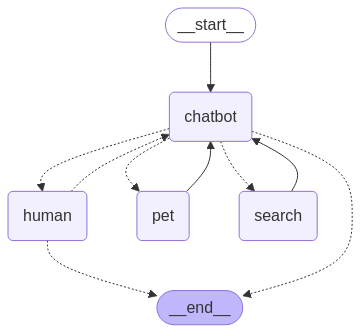

In [ ]:
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

search_tools = [care_guide_search, care_google_search]
search_node = ToolNode(search_tools)
pet_tools = [set_profile, update_profile, update_care]

llm_with_tools = llm.bind_tools(search_tools + pet_tools)

graph_builder = StateGraph(PetState)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human", human_node)
graph_builder.add_node("pet", pet_node)
graph_builder.add_node("search", search_node)

graph_builder.add_conditional_edges("human", exit_route)
graph_builder.add_conditional_edges("chatbot", tools_route)

graph_builder.add_edge(START, "chatbot")
#Tools
graph_builder.add_edge("search", "chatbot")
graph_builder.add_edge("pet", "chatbot")

chat_graph = graph_builder.compile()

Image(chat_graph.get_graph().draw_mermaid_png())

## 💡 Result Example

In [ ]:
# Uncomment line with invoke to test by yourself
# You can use this test data for pet profile:
# Luna is a lively three-year-old female Border Collie. She weighs 15.2 kg and has a high activity level – she loves long walks and playing with frisbees. She has been spayed and is generally healthy, although she has a mild allergy to chicken.

config = {"recursion_limit": 100}
state = chat_graph.invoke({"messages": []}, config)

Model: Hi, I’m Pet Care Assistant Bot (Type ‘q’ to quit).
Please tell me about your pet and I’ll help you create a personalized care plan and suggestions to keep them happy and healthy!
User: Luna is a lively three-year-old female Border Collie. She weighs 15.2 kg and has a high activity level – she loves long walks and playing with frisbees. She has been spayed and is generally healthy, although she has a mild allergy to chicken.
Model: OK, I've created a profile for Luna. What would you like to do next? For example, I can help with diet, health, or activity plans.
User: make diet plan
Model: To create a suitable diet plan for Luna, here are some guidelines to consider:

Adult dogs need 95 to 130 kilocalories per kilogram of metabolic body weight each day, but this can change based on her size, breed, activity level, and whether she is spayed.
A Border Collie that is moderately active and spayed might need about 800 to 950 kcal per day.
If Luna is a working dog and not spayed, she mig